<a href="https://www.kaggle.com/code/huienngu/boston-house-price-prediction-ml-svg?scriptVersionId=126635552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Introduction**

* Input: independent features
* Target: house price

# **Data analysis**
1. Correlation heatmap to finalize the relevant features set required for the analysis
2. Visualize the relation of independent features to the target variable Median house price using the reg-plot. 
3. Use boxplot to confirm the presence of outliers in the dataset

In [1]:
import pandas as pd

In [2]:
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 
    'LSTAT', 'MEDV']

house_price = pd.read_csv('/kaggle/input/boston-house-prices/housing.csv', 
                          header=None, 
                          delimiter=r"\s+", 
                          names=column_names)

In [3]:
house_price.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


House price dataset contains 13 independent features. 

<AxesSubplot:>

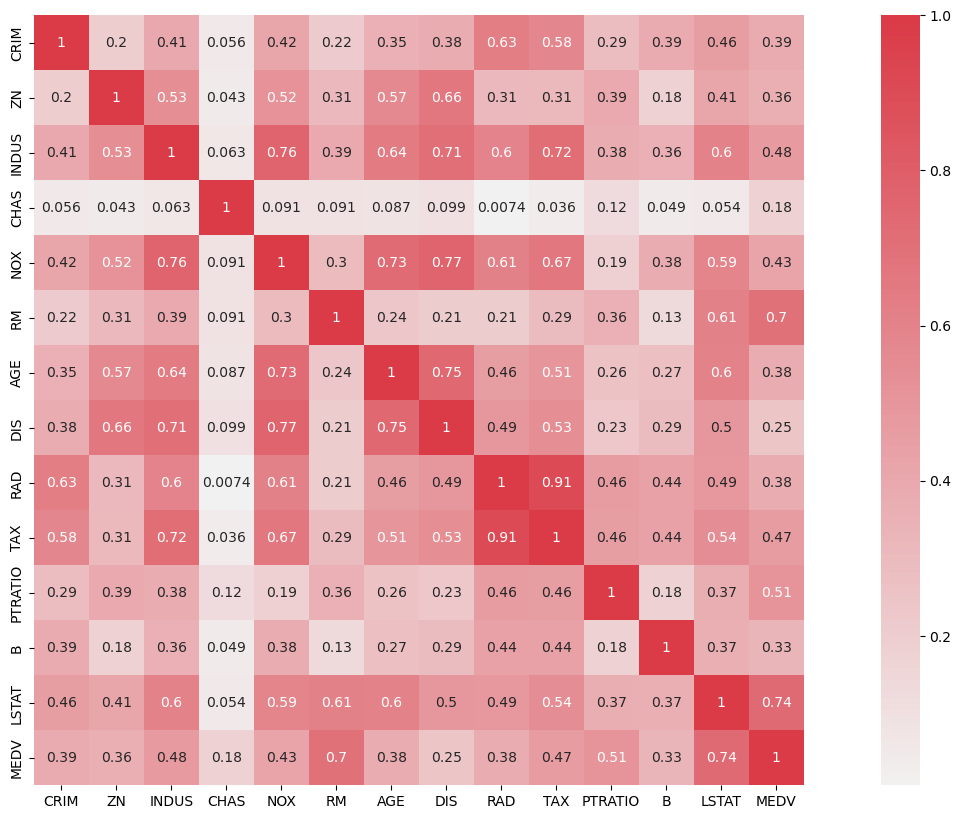

In [4]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(house_price.corr().abs(),cmap=cmap,center=0,square=True,annot=True)

TAX and RAD are highly correlated, and any one of them can be discarded. Also, LSTAT, RM, NOX, INDUS, PRTAIO, and TAX have a correlation greater than 0.4 with MEDV, which is a good indicator for using these parameters as predictors.

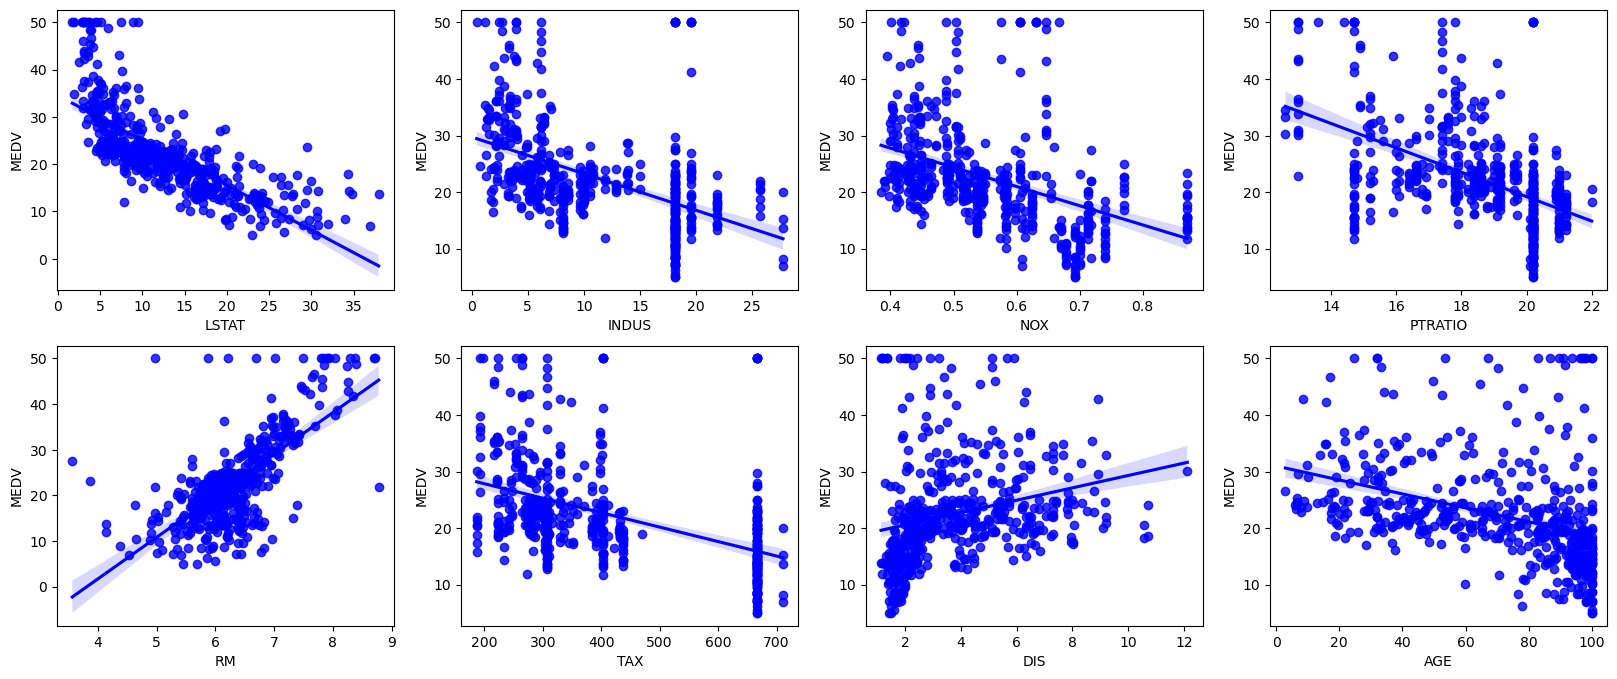

In [5]:
#scatterplot
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
cols = ['LSTAT','INDUS','NOX','PTRATIO','RM','TAX','DIS','AGE']
for col, ax in zip (cols,axs.flat):
    sns.regplot(x = house_price[col],y = house_price['MEDV'],color='blue',ax=ax)

The majority of features show a negative relationship to the house prices except for RM, DIS show a positive relationship.

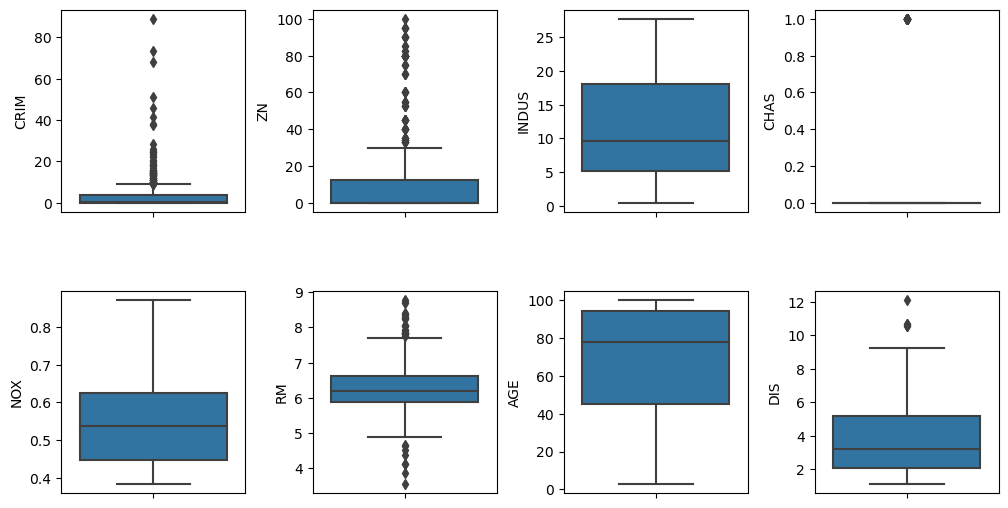

In [6]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(10, 5))
index = 0
axs = axs.flatten()
for k, v in house_price.items():
    if index < len(axs):
        sns.boxplot(y=k, data=house_price, ax=axs[index])
        index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Only RM seems to have some significant outliers.

In [7]:
#remove outliers
house_price = house_price[~((house_price['RM'] >=8.5) | (house_price['RM'] < 4))]

# **Model building**
1. Supervised regression algorithm


**Why choose SVR?**
1. Linear models - less complex, explainable but poorly perform on data containing outliers, fails to perform well on non-linear datasets
2. Non-linear regression models (Random forest regressor & XGBoost regressor) performs well in fitting the non-linear data
3. No significant outliers in dataset, thus linear as well as complex models can be used.

# **SVR**
* supervised machine learning algorithm that can be used for classification and regression
* find best-git hyper-plane along with the optimum threshold

**Criteria**
* simple & explainable
* provides accurate predictions
* robust to concept drift and outliers
* easy to deploy

In [8]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
target = house_price['MEDV']
features = house_price.drop('MEDV',axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3)
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

#baseline SVR model
regressor = SVR(kernel='rbf')
regressor.fit(X_train, Y_train)
regressor.score(X_test, Y_test)

#R-squared score: 0.705

0.5853051551384706

In [9]:
#implement SVR with hyper-parameter tuning:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
K = 15
parameters = [{'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9], 'C': [1, 10, 100, 1000, 10000]}]
print("Tuning hyper-parameters")
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr = GridSearchCV(SVR(epsilon=0.01), parameters, cv=K, scoring=scorer)
svr.fit(X_train, Y_train)
print("Grid scores on training set:")
means = svr.cv_results_['mean_test_score']
stds = svr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Tuning hyper-parameters
Grid scores on training set:
-84.332 (+/-51.642) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
-82.936 (+/-51.739) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
-72.051 (+/-53.694) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-49.318 (+/-55.849) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
-42.226 (+/-52.982) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
-34.068 (+/-49.016) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
-33.074 (+/-48.311) for {'C': 1, 'gamma': 0.6, 'kernel': 'rbf'}
-32.189 (+/-47.163) for {'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}
-82.933 (+/-51.740) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
-71.857 (+/-53.688) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
-47.381 (+/-55.846) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
-25.811 (+/-46.522) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
-21.639 (+/-43.906) for {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
-19.652 (+/-42.363) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
-19.279 (+/-41.570) for {'C': 10,

In [10]:
#best parameters at C=1000, gamma=0.9, kernel='rbf'
regressor_tuned = SVR(kernel='rbf',C=1000,gamma=0.9)
regressor_tuned.fit(X_train,Y_train)
regressor_tuned.score(X_test,Y_test)

#R-squared score: 0.821
#16.45% improvement in R squared score

0.8208319265364841

After hyper-parameter tuning, the R-squared score jumped from 0.70 (baseline SVR model) to 0.82 (hyper-tuned SVR model), which is a massive 16.45% overall improvement.

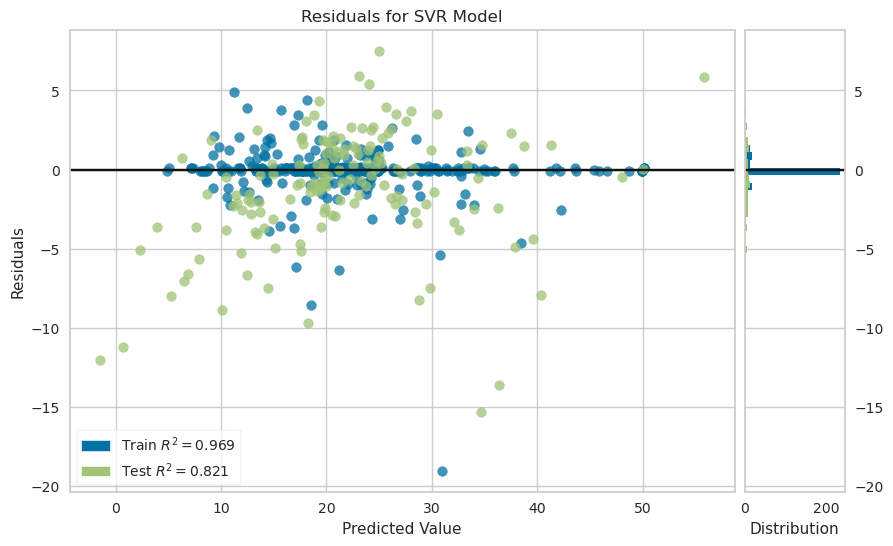

In [11]:
from yellowbrick.regressor import ResidualsPlot

plt.figure(figsize=(10,6))
visualizer = ResidualsPlot(regressor_tuned)
visualizer.fit(X_train,Y_train)
visualizer.score(X_test,Y_test)
visualizer.show();

Residuals are centered around zero, which indicates a good fit. Also, the R-squared score indicates a reliable fit for predicting house price.

# **Conclusion**
* The reuslts received from SVM are highly reliable and sufficient